# Step #1 Load the Data

In [4]:
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Tools for predictive data analysis. We will use the MinMaxScaler to normalize the price data 
from sklearn.preprocessing import MinMaxScaler 
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=date_start, end=date_today)

df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000


# Step #2 Explore the Data

In [5]:
# Changing the data structure to a dataframe with weekly price quotes
df["index1"] = range(1, len(df) + 1)
rownumber = df.shape[0]
lst = list(range(rownumber))
list_of_relevant_numbers = lst[0::7]
df_weekly = df[df["index1"].isin(list_of_relevant_numbers)]
df_weekly.head(5)

,Open,High,Low,Close,Adj Close,Volume,index1
Date,,,,,,,
2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000,7
2010-01-21,1138.680054,1141.579956,1114.839966,1116.479980,1116.479980,6874290000,14
2010-02-01,1073.890015,1089.380005,1073.890015,1089.189941,1089.189941,4077610000,21
2010-02-10,1069.680054,1073.670044,1059.339966,1068.130005,1068.130005,4251450000,28
2010-02-22,1110.000000,1112.290039,1105.380005,1108.010010,1108.010010,3814440000,35


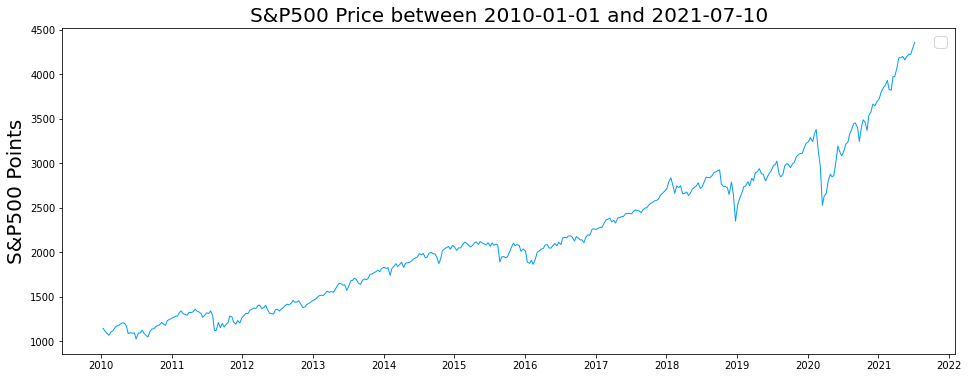

In [6]:
# Visualizing the data
register_matplotlib_converters()
years = mdates.YearLocator()
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df_weekly.index
y = df_weekly["Close"]
#ax1.fill_between(x, 0, y, color="#b9e1fa")
ax1.legend([stockname], fontsize=16)
plt.title(stockname + " Price between " + date_start + " and " + date_today, fontsize=20)
plt.plot(y, color="#039dfc", label="S&P500", linewidth=1.0)
plt.ylabel("S&P500 Points", fontsize=20)
plt.show()

# Step #3 Preprocess the Data

In [7]:
# Feature Selection - Only Close Data
train_df = df.filter(['Close'])
data_unscaled = df.values

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 25

# Prediction Index
index_Close = train_df.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_length, :]
test_data = np_data[train_data_length - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

(2270, 50, 7) (2270,)
(580, 50, 7) (580,)
0.545801661783881
0.545801661783881


# Step #4 Train the Model

In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons Neurons
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

350 50 7


In [10]:
# Training the model
epochs = 10
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=16, 
                    epochs=epochs, 
                    callbacks=[early_stop])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
142/142 [==============================] - 7s 10ms/step - loss: 0.0013
Epoch 2/10
142/142 [==============================] - 1s 10ms/step - loss: 1.4388e-04
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 1.2273e-04
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 7.9983e-05
Epoch 5/10
142/142 [==============================] - 1s 10ms/step - loss: 8.4474e-05
Epoch 6/10
142/142 [==============================] - 1s 10ms/step - loss: 7.5285e-05
Epoch 7/10
142/142 [==============================] - 1s 10ms/step - loss: 8.9030e-05
Epoch 8/10
142/142 [==============================] - 1s 10ms/step - loss: 6.0849e-05
Epoch 9/10
142/142 [==============================] - 1s 10ms/step - loss: 5.8924e-05
Epoch 10/10
142/142 [==============================] - 1s 10ms/step - loss: 4.6130e-05


# Step #5 Evaluate Model Performance

Median Absolute Error (MAE): 79.76
Mean Absolute Percentage Error (MAPE): 2.3 %
Median Absolute Percentage Error (MDAPE): 2.12 %


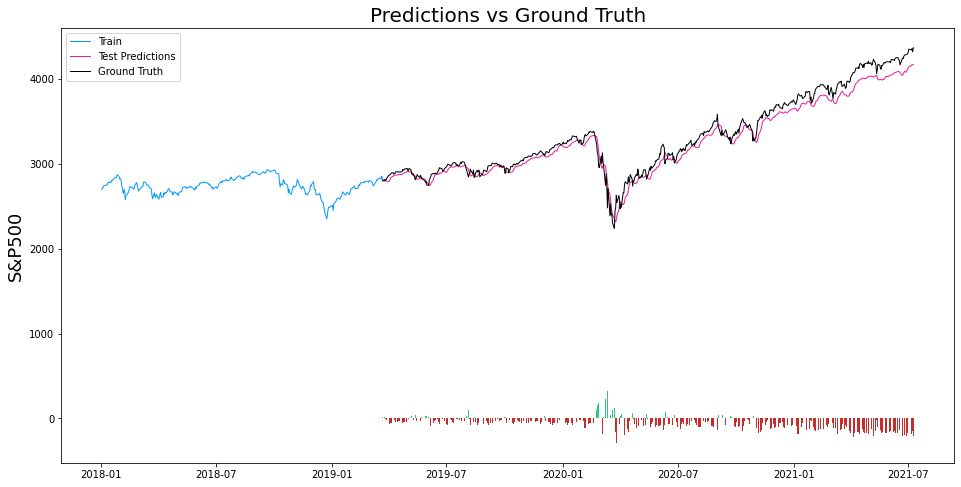

In [11]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = train_df[:train_data_length + 1]
valid = train_df[train_data_length:]
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax = plt.subplots(figsize=(16, 8), sharex=True)

plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(train["Close"], color="#039dfc", linewidth=1.0)
plt.plot(valid["Predictions"], color="#E91D9E", linewidth=1.0)
plt.plot(valid["Close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

# Create the bar plot with the differences
valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

# Step #6 Predict Next Weeks's Price

In [13]:
# Get fresh data until today and create a new dataframe with only the price data

new_df = df

N = sequence_length

# Get the last N steps closing price values and scale the data to be values between 0 and 1
last_N_steps = new_df[-sequence_length:].values
last_N_steps_scaled = mmscaler.transform(last_N_steps)

# Create an empty list and Append past N steps
X_test_new = []
X_test_new.append(last_N_steps_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next week
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for S&P500 at 2021-07-10 was 4369.55
The predicted close price is 4173.169921875 (-4.71%)
